<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignments/blob/main/NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
#import wandb

In [8]:
# load dataset
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# DNN functions

**weight initialization function**

In [9]:
def weights_initialization(num_neurons, initializer):
  """
  num_neurons = list of number of neurons at each layer starting from the input layer and ending at output layer
  initializer = 'random' or 'xavier'

  Returns: initialized weight matrices and bias vectors
  """
  mean=0
  std_dev=1

  W_matrices = []
  b_vectors = []

  for i in range(len(num_neurons)-1):
    rows = num_neurons[i+1]
    cols = num_neurons[i]

    if initializer == 'random':

      weight_matrix = np.random.normal(mean, std_dev, size=(rows, cols))

    elif initializer == 'Xavier':

      upper_bound = np.sqrt(6.0/(rows + cols))
      lower_bound = -1*upper_bound
      weight_matrix = np.random.uniform(low = lower_bound, high = upper_bound, size = (rows, cols))

    else:
      print('initializer invalid')


    bias_vector = np.zeros((rows,1))

    W_matrices.append(weight_matrix)
    b_vectors.append(bias_vector)


  return W_matrices, b_vectors

**activation functions**

In [10]:
# ACTIVATION FUNCTIONS
def relu(x):
  """
  Rectified Linear Unit (ReLU) activation function
  """
  return np.maximum(0, x)

def sigmoid(x):
  """
  Sigmoid activation function
  """
  # x = np.float128(x)
  return 1 / (1 + np.exp(-x))

def tanh(x):
  """
  Hyperbolic tangent (tanh) activation function
  """
  # x = np.float128(x)
  return np.tanh(x)
def softmax(x):

  """
  Softmax function for output layer
  """
  # x = np.float128(x)
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def activation_output(x, activation_function):
  """
  activation_function = 'ReLU', 'sigmoid', 'tanh'
  """
  if activation_function == 'ReLU':
    return relu(x)
  elif activation_function == 'sigmoid':
    return sigmoid(x)
  elif activation_function == 'tanh':
    return tanh(x)
  elif activation_function == 'softmax':
    return softmax(x)
  else:
    print('activation function invalid')

# DERIVATIVE OF ACTIVATION FUNCTION
def sigmoid_derivative(x):
  s = sigmoid(x)
  return s * (1 - s)

def tanh_derivative(x):
  t = tanh(x)
  return 1 - t**2

def relu_derivative(x):
  return 1*(x>0)

def activation_derivative(x, activation_function):
  """
  activation_function = 'ReLU', 'sigmoid', 'tanh'
  """
  if activation_function == 'ReLU':
    return relu_derivative(x)
  elif activation_function == 'sigmoid':
    return sigmoid_derivative(x)
  elif activation_function == 'tanh':
    return tanh_derivative(x)
  else:
    print('activation function invalid')

**forward propagation**

In [11]:
def layer_output_FP(x, weight_matrix, bias_vector, activation_function):
  pre_activation = np.add(np.matmul(weight_matrix, x), bias_vector)
  post_activation = activation_output(pre_activation, activation_function)
  return pre_activation, post_activation

def forward_propagation(ip_data, W_matrices, b_vectors, activation_functions):
  """
  forward propagation
  """

  layer_op = []
  layer_op.append(ip_data)

  layer_ip = []

  for i in range(len(W_matrices)):

    weight_matrix = W_matrices[i]
    bias_vector = b_vectors[i]

    activation_function = activation_functions[i]

    pre_activation, post_activation = layer_output_FP(layer_op[i], weight_matrix, bias_vector, activation_function)

    layer_op.append(post_activation)
    layer_ip.append(pre_activation)

  return layer_ip, layer_op



**back propagation**

In [12]:
def back_propagation(W_matrices, b_vectors, y_true, layer_ip, layer_op, activation_functions, batch_size, w_d):

  DWs = []
  Dbs = []
  for i in range(len(W_matrices)):
    k = len(W_matrices) - i

    if k == len(W_matrices):
      Da = -np.add(y_true, -layer_op[k])
      Dw = (np.matmul(Da, layer_op[k-1].T) + w_d*W_matrices[k-1])/batch_size
    else:

      Dh = np.matmul(W_matrices[k].T, Da)
      Dg = activation_derivative(layer_ip[k-1], activation_functions[k-1])
      Da = np.multiply(Dh, Dg)
      Dw = (np.matmul(Da, layer_op[k-1].T) + w_d*W_matrices[k-1])/batch_size
    Db = np.sum(Da, axis=1, keepdims=True)/batch_size

    DWs.append(Dw)
    Dbs.append(Db)

  return DWs, Dbs





In [13]:
def update_weights_gd(W_matrices, b_vectors, DWs, Dbs, learning_rate = 0.1):

  DWs.reverse()
  Dbs.reverse()

  for i in range(len(DWs)):

    W_matrices[i] = W_matrices[i] - learning_rate*DWs[i]
    b_vectors[i] = b_vectors[i] - learning_rate*Dbs[i]
  return W_matrices, b_vectors

In [14]:
def update_weights_momentum(W_matrices, b_vectors, DWs, Dbs, u_past_w, u_past_b, learning_rate = 0.1, beta = 0.5):
  DWs.reverse()
  Dbs.reverse()
  u_w = u_past_w
  u_b = u_past_b
  for i in range(len(DWs)):

    u_w[i] = beta*u_past_w[i] + DWs[i]
    u_b[i] = beta*u_past_b[i] + Dbs[i]

    W_matrices[i] = W_matrices[i] - learning_rate*u_w[i]
    b_vectors[i] = b_vectors[i] - learning_rate*u_b[i]

  return W_matrices, b_vectors, u_w, u_b

In [15]:
def update_weights_adagrad(W_matrices, b_vectors, DWs, Dbs, u_past_w, u_past_b, learning_rate = 0.1):
  DWs.reverse()
  Dbs.reverse()

  u_w = u_past_w
  u_b = u_past_b
  eps = 1e-8
  for i in range(len(DWs)):
    u_w[i] = u_past_w[i] + DWs[i]**2
    u_b[i] = u_past_b[i] + Dbs[i]**2

    W_matrices[i] = W_matrices[i] - learning_rate*DWs[i]/(np.sqrt(u_w[i]) + eps)
    b_vectors[i] = b_vectors[i] - learning_rate*Dbs[i]/(np.sqrt(u_b[i]) + eps)

  return W_matrices, b_vectors, u_w, u_b

In [16]:
def update_weights_rmsprop(W_matrices, b_vectors, DWs, Dbs, u_past_w, u_past_b, learning_rate = 0.1, beta = 0.5):
  DWs.reverse()
  Dbs.reverse()

  u_w = u_past_w
  u_b = u_past_b
  eps = 1e-8
  for i in range(len(DWs)):
    u_w[i] = beta*u_past_w[i] + (1-beta)*DWs[i]**2
    u_b[i] = beta*u_past_b[i] + (1-beta)*Dbs[i]**2

    W_matrices[i] = W_matrices[i] - learning_rate*DWs[i]/(np.sqrt(u_w[i]) + eps)
    b_vectors[i] = b_vectors[i] - learning_rate*Dbs[i]/(np.sqrt(u_b[i]) + eps)

  return W_matrices, b_vectors, u_w, u_b

In [17]:
def update_weights_adam(W_matrices, b_vectors, DWs, Dbs, mw_past, mb_past, vw_past, vb_past, t, learning_rate = 0.1, beta1 = 0.5, beta2 =0.5):
  DWs.reverse()
  Dbs.reverse()
  mw = mw_past
  mb = mb_past
  vw = vw_past
  vb = vb_past
  eps = 1e-8

  for i in range(len(DWs)):
    mw[i] = beta1*mw_past[i] + (1-beta1)*DWs[i]
    mb[i] = beta1*mb_past[i] + (1-beta1)*Dbs[i]

    mw_cap = mw[i]/(1 - beta1**t)
    mb_cap = mb[i]/(1 - beta1**t)

    vw[i] = beta2*vw_past[i] + (1-beta2)*DWs[i]**2
    vb[i] = beta2*vb_past[i] + (1-beta2)*Dbs[i]**2
    vw_cap = vw[i]/(1 - beta2**t)
    vb_cap = vb[i]/(1 - beta2**t)

    W_matrices[i] = W_matrices[i] - learning_rate*mw_cap/(np.sqrt(vw_cap) + eps)
    b_vectors[i] = b_vectors[i] - learning_rate*mb_cap/(np.sqrt(vb_cap) + eps)

  return W_matrices, b_vectors, mw, mb, vw, vb

In [18]:
def update_weights_nadam(W_matrices, b_vectors, DWs, Dbs, mw_past, mb_past, vw_past, vb_past,t,  learning_rate = 0.1, beta1 = 0.5, beta2 =0.5):
  DWs.reverse()
  Dbs.reverse()
  mw = mw_past
  mb = mb_past
  vw = vw_past
  vb = vb_past
  eps = 1e-8

  for i in range(len(DWs)):
    mw[i] = beta1*mw_past[i] + (1-beta1)*DWs[i]
    mb[i] = beta1*mb_past[i] + (1-beta1)*Dbs[i]

    mw_cap = mw[i]/(1 - beta1**(t+1))
    mb_cap = mb[i]/(1 - beta1**(t+1))

    vw[i] = beta2*vw_past[i] + (1-beta2)*DWs[i]**2
    vb[i] = beta2*vb_past[i] + (1-beta2)*Dbs[i]**2
    vw_cap = vw[i]/(1 - beta2**(t+1))
    vb_cap = vb[i]/(1 - beta2**(t+1))

    W_matrices[i] = W_matrices[i] - learning_rate*(beta1*mw_cap + ((1-beta1)/(1 - beta1**(t+1)))*DWs[i])/(np.sqrt(vw_cap) + eps)
    b_vectors[i] = b_vectors[i] - learning_rate*(beta1*mb_cap + ((1-beta1)/(1 - beta1**(t+1)))*Dbs[i])/(np.sqrt(vb_cap) + eps)

  return W_matrices, b_vectors, mw, mb, vw, vb

In [19]:
def look_ahead_nag(W_s, b_s, u_past_w, u_past_b, beta = 0.5):
  for i in range(len(W_s)):
    W_s[i] = W_s[i] - beta*u_past_w[i]
    b_s[i] = b_s[i] - beta*u_past_b[i]
  return W_s, b_s

**model training function**

In [20]:
def one_hot_encode(integers, num_classes=None):
  if num_classes is None:
      num_classes = np.max(integers) + 1
  return np.eye(num_classes)[integers]

def cross_entropy_loss(y_true, y_pred, batch_size):
  # Clip the predicted probabilities to avoid numerical instability
  y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
  loss_value = np.sum(np.sum(y_true*np.log(y_pred), axis=0))/batch_size
  return loss_value*(-1)



def accuracy(y_true, y_pred, batch_size):
  n_correct = 0
  for i in range(0, batch_size, 1) :
    if y_true[:,i].argmax() == y_pred[:,i].argmax() :
      n_correct += 1
  return 100 * n_correct / batch_size

In [45]:

def train_model(X_train,Y_train, X_test, Y_test, epoch=1,batch_size=25, num_neurons_hidden = [10], activation_functions = ['sigmoid'],
                weights_init_type='random', optimizer = 'sgd', learning_rate = 0.1, opti_beta = [0.5, 0.5], w_d = 0, plot_acc_loss = False):

  """
  X has shape (number of features, number of samples in train data set)
  Y has shape (number of classes, number of samples in train data set)

  num_neurons_hidden = list of number of neurons at each hidden layer

  """
  num_ip_neurons = X_train.shape[0]
  num_op_neurons = Y_train.shape[0]
  num_neurons = [num_ip_neurons] + num_neurons_hidden + [num_op_neurons]
  activation_functions = activation_functions + ['softmax']

  W_s, b_s = weights_initialization(num_neurons, weights_init_type)
  print('Hyper parameters: \n')
  print("Weight initialization type : ", weights_init_type)
  print("Optimizer : ", optimizer)
  print("Learning rate (initial): ", learning_rate)
  print("-------------------")
  print("Architecture Description:\n")

  for i in range(len(num_neurons)-1):
    print("Layer: ", i+1, " ; number of neurons: ", num_neurons[i+1], " ; activation function: ", activation_functions[i])
    print("Weight matrix dimention", W_s[i].shape, "Bias vector dimention", b_s[i].shape)
    print("----------------")

  num_batches = np.floor(X_train.shape[1]/batch_size)
  print(num_batches)

  print('\n Start of training')

  if optimizer == 'momentum':
    u_past_w = [x * 0 for x in W_s]
    u_past_b = [x * 0 for x in b_s]

  elif optimizer == 'nag':
    u_past_w = [x * 0 for x in W_s]
    u_past_b = [x * 0 for x in b_s]

  elif optimizer == 'rmsprop':
    u_past_w = [x * 0 for x in W_s]
    u_past_b = [x * 0 for x in b_s]

  elif optimizer == 'adagrad':
    u_past_w = [x * 0 for x in W_s]
    u_past_b = [x * 0 for x in b_s]

  elif optimizer == 'adam':
    mw_past = [x * 0 for x in W_s]
    mb_past = [x * 0 for x in b_s]
    vw_past = [x * 0 for x in W_s]
    vb_past = [x * 0 for x in b_s]
    t = 1

  elif optimizer == 'nadam':
    mw_past = [x * 0 for x in W_s]
    mb_past = [x * 0 for x in b_s]
    vw_past = [x * 0 for x in W_s]
    vb_past = [x * 0 for x in b_s]
    t = 1

  ip_all, op_all = forward_propagation(X_train, W_s, b_s, activation_functions)
  loss_tr = cross_entropy_loss(Y_train, op_all[-1], X_train.shape[1])
  acc = accuracy(Y_train, op_all[-1], batch_size)
  print("Error at the start:")
  print("Training Loss: ", loss_tr)
  print("Training Accuracy: ", acc)
  train_loss = np.array([loss_tr])
  train_acc = np.array([acc])

  ip_all, op_all = forward_propagation(X_test, W_s, b_s, activation_functions)
  loss_ts = cross_entropy_loss(Y_test, op_all[-1], X_test.shape[1])
  acc = accuracy(Y_test, op_all[-1], batch_size)
  print("Test Loss: ", loss_ts)
  print("Testing Accuracy: ", acc)
  val_loss = np.array([loss_ts])
  val_acc = np.array([acc])

  for i in range(epoch):
    print('Epoch: ', i+1)

    for j in tqdm(range(int(num_batches))):
      batch_X = X_train[:,j*batch_size:(j+1)*batch_size]
      batch_Y = Y_train[:,j*batch_size:(j+1)*batch_size]


      if optimizer == 'sgd':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s = update_weights_gd(W_s, b_s, DWs, Dbs, learning_rate)

      elif optimizer == 'momentum':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, u_past_w, u_past_b  = update_weights_momentum(W_s, b_s, DWs, Dbs, u_past_w, u_past_b, learning_rate, opti_beta[0])

      elif optimizer == 'adagrad':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, u_past_w, u_past_b  = update_weights_adagrad(W_s, b_s, DWs, Dbs, u_past_w, u_past_b, learning_rate)

      elif optimizer == 'rmsprop':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, u_past_w, u_past_b  = update_weights_rmsprop(W_s, b_s, DWs, Dbs, u_past_w, u_past_b, learning_rate, opti_beta[0])

      elif optimizer == 'adam':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, mw_past, mb_past, vw_past, vb_past = update_weights_adam(W_s, b_s, DWs, Dbs, mw_past, mb_past, vw_past, vb_past, t, learning_rate, opti_beta[0], opti_beta[1])
        t =t +1

      elif optimizer == 'nadam':
        ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
        DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, mw_past, mb_past, vw_past, vb_past = update_weights_nadam(W_s, b_s, DWs, Dbs, mw_past, mb_past, vw_past, vb_past, t, learning_rate, opti_beta[0], opti_beta[1])
        t =t +1
      elif optimizer == 'nag':
        PWs, Pbs = look_ahead_nag(W_s, b_s, u_past_w, u_past_b, opti_beta[0])
        ip, op = forward_propagation(batch_X, PWs, Pbs, activation_functions)
        DWs, Dbs = back_propagation(PWs, Pbs, batch_Y, ip, op, activation_functions, batch_size, w_d)
        W_s, b_s, u_past_w, u_past_b  = update_weights_momentum(W_s, b_s, DWs, Dbs, u_past_w, u_past_b, learning_rate, opti_beta[0])


    ip_all, op_all = forward_propagation(X_train, W_s, b_s, activation_functions)
    loss_tr = cross_entropy_loss(Y_train, op_all[-1], X_train.shape[1])
    acc = accuracy(Y_train, op_all[-1], Y_train.shape[1])
    print("Training Loss: ", loss_tr)
    print("Training Accuracy: ", acc)
    train_loss = np.append(train_loss, [loss_tr])
    train_acc = np.append(train_acc, [acc])

    ip_all, op_all = forward_propagation(X_test, W_s, b_s, activation_functions)
    loss_ts = cross_entropy_loss(Y_test, op_all[-1], X_test.shape[1])
    acc = accuracy(Y_test, op_all[-1], Y_test.shape[1])
    print("Batch size: ", batch_size)
    print("Test Loss: ", loss_ts)
    print("Testing Accuracy: ", acc)
    val_loss = np.append(val_loss, [loss_ts])
    val_acc = np.append(val_acc, [acc])


  if plot_acc_loss == True:

    fig, ax = plt.subplots()  # Create a figure and axes object
    ax.plot(np.arange(0, epoch + 1, 1), train_acc, color='r', label='training')
    ax.plot(np.arange(0, epoch + 1, 1), val_acc, color='g', label='validation')
    ax.set_title("Accuracy")  # Set title on the axes object
    ax.legend()
    plt.grid()
    plt.show()

    fig, ax = plt.subplots()  # Create a figure and axes object for the second plot
    ax.plot(np.arange(0, epoch + 1, 1), train_loss, color='r', label='training')
    ax.plot(np.arange(0, epoch + 1, 1), val_loss, color='g', label='validation')
    ax.set_title("Loss")  # Set title on the axes object
    ax.legend()
    plt.grid()
    plt.show()


In [27]:
def load_split_dataset(test_ratio):
  # Load Fashion MNIST dataset
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  # Split the training set into training and validation sets
  X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=test_ratio, random_state=42)

  data_size = X_train.shape[0]
  X_train = (X_train.reshape(data_size, -1).T)/255
  Y_train = one_hot_encode(Y_train, 10).T

  data_size = X_val.shape[0]
  X_val = (X_val.reshape(data_size, -1).T)/255
  Y_val = one_hot_encode(Y_val, 10).T

  data_size = test_images.shape[0]
  X_test = (test_images.reshape(data_size, -1).T)/255
  Y_test = one_hot_encode(test_labels, 10).T

  return X_train, Y_train, X_val, Y_val, X_test, Y_test

# Training

In [42]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split_dataset(0.98)


In [46]:
print("Shape: Training data = ", X_train.shape, " Training labels = ", Y_train.shape)
print("Shape: Validation data = ", X_val.shape, " Validation labels = ", Y_val.shape)
print("Shape: Testing data = ", X_test.shape, " Testing labels = ", Y_test.shape)

epochs = 200
nhl = 3
sz = 64
w_d = 0
lr = 0.0001
optimizer = 'adam'
b_sz = 16
weight_init = 'Xavier'
act_fun = 'ReLU'

neuros_num = []
act_func = []
for i in range(nhl):
  neuros_num.append(sz)
  act_func.append(act_fun)
print("Number of neurons/nodes in each hidden layer = ", neuros_num)
print("Activation Function of each hidden layer = ", act_func)

Shape: Training data =  (784, 1200)  Training labels =  (10, 1200)
Shape: Validation data =  (784, 58800)  Validation labels =  (10, 58800)
Shape: Testing data =  (784, 10000)  Testing labels =  (10, 10000)
Number of neurons/nodes in each hidden layer =  [64, 64, 64]
Activation Function of each hidden layer =  ['ReLU', 'ReLU', 'ReLU']


Hyper parameters: 

Weight initialization type :  Xavier
Optimizer :  adam
Learning rate (initial):  0.0001
-------------------
Architecture Description:

Layer:  1  ; number of neurons:  64  ; activation function:  ReLU
Weight matrix dimention (64, 784) Bias vector dimention (64, 1)
----------------
Layer:  2  ; number of neurons:  64  ; activation function:  ReLU
Weight matrix dimention (64, 64) Bias vector dimention (64, 1)
----------------
Layer:  3  ; number of neurons:  64  ; activation function:  ReLU
Weight matrix dimention (64, 64) Bias vector dimention (64, 1)
----------------
Layer:  4  ; number of neurons:  10  ; activation function:  softmax
Weight matrix dimention (10, 64) Bias vector dimention (10, 1)
----------------
75.0

 Start of training
Error at the start:
Training Loss:  2.3438462545106113
Training Accuracy:  6.25
Test Loss:  2.3469882423747004
Testing Accuracy:  6.25
Epoch:  1


100%|██████████| 75/75 [00:00<00:00, 486.68it/s]


Training Loss:  2.0953738351669378
Training Accuracy:  26.083333333333332
Batch size:  16
Test Loss:  2.102080002909625
Testing Accuracy:  26.28
Epoch:  2


100%|██████████| 75/75 [00:00<00:00, 426.67it/s]


Training Loss:  1.819011004047973
Training Accuracy:  54.0
Batch size:  16
Test Loss:  1.8313516644591894
Testing Accuracy:  53.07
Epoch:  3


100%|██████████| 75/75 [00:00<00:00, 474.02it/s]


Training Loss:  1.5227958805250432
Training Accuracy:  61.333333333333336
Batch size:  16
Test Loss:  1.5429233194538023
Testing Accuracy:  59.79
Epoch:  4


100%|██████████| 75/75 [00:00<00:00, 471.21it/s]


Training Loss:  1.3029573487164339
Training Accuracy:  62.833333333333336
Batch size:  16
Test Loss:  1.3298569162051856
Testing Accuracy:  62.46
Epoch:  5


100%|██████████| 75/75 [00:00<00:00, 509.94it/s]


Training Loss:  1.149164095382391
Training Accuracy:  63.833333333333336
Batch size:  16
Test Loss:  1.1834129883617823
Testing Accuracy:  63.65
Epoch:  6


100%|██████████| 75/75 [00:00<00:00, 501.12it/s]


Training Loss:  1.0334622244070528
Training Accuracy:  65.5
Batch size:  16
Test Loss:  1.0744711388916233
Testing Accuracy:  64.75
Epoch:  7


100%|██████████| 75/75 [00:00<00:00, 502.31it/s]


Training Loss:  0.9431596093394078
Training Accuracy:  66.83333333333333
Batch size:  16
Test Loss:  0.9915099457191638
Testing Accuracy:  65.5
Epoch:  8


100%|██████████| 75/75 [00:00<00:00, 448.64it/s]


Training Loss:  0.8736253907065702
Training Accuracy:  69.25
Batch size:  16
Test Loss:  0.9293239145176356
Testing Accuracy:  67.34
Epoch:  9


100%|██████████| 75/75 [00:00<00:00, 440.39it/s]


Training Loss:  0.8204464513678935
Training Accuracy:  71.41666666666667
Batch size:  16
Test Loss:  0.8823623004174574
Testing Accuracy:  69.2
Epoch:  10


100%|██████████| 75/75 [00:00<00:00, 495.29it/s]


Training Loss:  0.7775132612388532
Training Accuracy:  72.66666666666667
Batch size:  16
Test Loss:  0.845859756680274
Testing Accuracy:  70.46
Epoch:  11


100%|██████████| 75/75 [00:00<00:00, 488.04it/s]


Training Loss:  0.7414990032171526
Training Accuracy:  74.0
Batch size:  16
Test Loss:  0.8159873817109145
Testing Accuracy:  71.78
Epoch:  12


100%|██████████| 75/75 [00:00<00:00, 522.80it/s]


Training Loss:  0.7099033155345192
Training Accuracy:  75.0
Batch size:  16
Test Loss:  0.7907373033544088
Testing Accuracy:  72.64
Epoch:  13


100%|██████████| 75/75 [00:00<00:00, 447.05it/s]


Training Loss:  0.6817803781185598
Training Accuracy:  76.41666666666667
Batch size:  16
Test Loss:  0.7689233643854619
Testing Accuracy:  73.69
Epoch:  14


100%|██████████| 75/75 [00:00<00:00, 476.44it/s]


Training Loss:  0.6567273336886894
Training Accuracy:  77.0
Batch size:  16
Test Loss:  0.7499781961360557
Testing Accuracy:  74.55
Epoch:  15


100%|██████████| 75/75 [00:00<00:00, 442.57it/s]


Training Loss:  0.6351924251771128
Training Accuracy:  77.58333333333333
Batch size:  16
Test Loss:  0.7340853983382674
Testing Accuracy:  75.12
Epoch:  16


100%|██████████| 75/75 [00:00<00:00, 474.47it/s]


Training Loss:  0.6156002139014831
Training Accuracy:  78.41666666666667
Batch size:  16
Test Loss:  0.719977291519044
Testing Accuracy:  75.53
Epoch:  17


100%|██████████| 75/75 [00:00<00:00, 426.00it/s]


Training Loss:  0.5975481384868148
Training Accuracy:  79.33333333333333
Batch size:  16
Test Loss:  0.7072120608594336
Testing Accuracy:  76.06
Epoch:  18


100%|██████████| 75/75 [00:00<00:00, 462.42it/s]


Training Loss:  0.5811632595650097
Training Accuracy:  80.0
Batch size:  16
Test Loss:  0.6955714780725409
Testing Accuracy:  76.47
Epoch:  19


100%|██████████| 75/75 [00:00<00:00, 419.25it/s]


Training Loss:  0.5653260756565559
Training Accuracy:  80.5
Batch size:  16
Test Loss:  0.6850981600474958
Testing Accuracy:  76.9
Epoch:  20


100%|██████████| 75/75 [00:00<00:00, 493.78it/s]


Training Loss:  0.5513730625057598
Training Accuracy:  81.0
Batch size:  16
Test Loss:  0.6757440011426705
Testing Accuracy:  77.24
Epoch:  21


100%|██████████| 75/75 [00:00<00:00, 508.19it/s]


Training Loss:  0.5379849581955353
Training Accuracy:  81.0
Batch size:  16
Test Loss:  0.6676602145826716
Testing Accuracy:  77.45
Epoch:  22


100%|██████████| 75/75 [00:00<00:00, 473.00it/s]


Training Loss:  0.5255110142432148
Training Accuracy:  81.41666666666667
Batch size:  16
Test Loss:  0.6602428818892249
Testing Accuracy:  77.74
Epoch:  23


100%|██████████| 75/75 [00:00<00:00, 477.70it/s]


Training Loss:  0.5138937770863652
Training Accuracy:  81.58333333333333
Batch size:  16
Test Loss:  0.6536057820894803
Testing Accuracy:  77.99
Epoch:  24


100%|██████████| 75/75 [00:00<00:00, 408.40it/s]


Training Loss:  0.5029590112062423
Training Accuracy:  82.41666666666667
Batch size:  16
Test Loss:  0.6478549611363896
Testing Accuracy:  78.25
Epoch:  25


100%|██████████| 75/75 [00:00<00:00, 494.42it/s]


Training Loss:  0.49242731313432386
Training Accuracy:  82.66666666666667
Batch size:  16
Test Loss:  0.642423538806717
Testing Accuracy:  78.45
Epoch:  26


100%|██████████| 75/75 [00:00<00:00, 472.40it/s]


Training Loss:  0.48241773774840035
Training Accuracy:  83.08333333333333
Batch size:  16
Test Loss:  0.637613734858379
Testing Accuracy:  78.7
Epoch:  27


100%|██████████| 75/75 [00:00<00:00, 506.27it/s]


Training Loss:  0.4729812058429634
Training Accuracy:  83.41666666666667
Batch size:  16
Test Loss:  0.6335729674469168
Testing Accuracy:  78.88
Epoch:  28


100%|██████████| 75/75 [00:00<00:00, 413.02it/s]


Training Loss:  0.46413627812433883
Training Accuracy:  83.83333333333333
Batch size:  16
Test Loss:  0.6294188422081923
Testing Accuracy:  79.1
Epoch:  29


100%|██████████| 75/75 [00:00<00:00, 469.30it/s]


Training Loss:  0.45565759517299154
Training Accuracy:  84.25
Batch size:  16
Test Loss:  0.6259051818942287
Testing Accuracy:  79.3
Epoch:  30


100%|██████████| 75/75 [00:00<00:00, 496.77it/s]


Training Loss:  0.44758304770797147
Training Accuracy:  84.41666666666667
Batch size:  16
Test Loss:  0.6226328848986277
Testing Accuracy:  79.49
Epoch:  31


100%|██████████| 75/75 [00:00<00:00, 449.13it/s]


Training Loss:  0.4397421292736753
Training Accuracy:  84.58333333333333
Batch size:  16
Test Loss:  0.6196794544751564
Testing Accuracy:  79.6
Epoch:  32


100%|██████████| 75/75 [00:00<00:00, 427.25it/s]


Training Loss:  0.43181457221184133
Training Accuracy:  84.75
Batch size:  16
Test Loss:  0.61677835617129
Testing Accuracy:  79.73
Epoch:  33


100%|██████████| 75/75 [00:00<00:00, 188.29it/s]


Training Loss:  0.42449938011552296
Training Accuracy:  85.08333333333333
Batch size:  16
Test Loss:  0.6143709725034587
Testing Accuracy:  79.76
Epoch:  34


100%|██████████| 75/75 [00:00<00:00, 184.87it/s]


Training Loss:  0.41732017783483566
Training Accuracy:  85.33333333333333
Batch size:  16
Test Loss:  0.6124071102217655
Testing Accuracy:  79.87
Epoch:  35


100%|██████████| 75/75 [00:00<00:00, 182.86it/s]


Training Loss:  0.4104204661595233
Training Accuracy:  85.75
Batch size:  16
Test Loss:  0.6104320712340123
Testing Accuracy:  79.97
Epoch:  36


100%|██████████| 75/75 [00:00<00:00, 212.31it/s]


Training Loss:  0.40362933870859585
Training Accuracy:  85.91666666666667
Batch size:  16
Test Loss:  0.6090609995830076
Testing Accuracy:  80.11
Epoch:  37


100%|██████████| 75/75 [00:00<00:00, 166.55it/s]


Training Loss:  0.39701483680833954
Training Accuracy:  86.33333333333333
Batch size:  16
Test Loss:  0.607429810797232
Testing Accuracy:  80.1
Epoch:  38


100%|██████████| 75/75 [00:00<00:00, 174.17it/s]


Training Loss:  0.39074967910432423
Training Accuracy:  86.75
Batch size:  16
Test Loss:  0.6064861401990294
Testing Accuracy:  80.11
Epoch:  39


100%|██████████| 75/75 [00:00<00:00, 488.74it/s]


Training Loss:  0.38441790703709655
Training Accuracy:  87.0
Batch size:  16
Test Loss:  0.6058043365256128
Testing Accuracy:  80.14
Epoch:  40


100%|██████████| 75/75 [00:00<00:00, 417.32it/s]


Training Loss:  0.37818838386779086
Training Accuracy:  87.33333333333333
Batch size:  16
Test Loss:  0.605167458228991
Testing Accuracy:  80.23
Epoch:  41


100%|██████████| 75/75 [00:00<00:00, 513.03it/s]


Training Loss:  0.37243152032491206
Training Accuracy:  87.5
Batch size:  16
Test Loss:  0.6049906029261309
Testing Accuracy:  80.26
Epoch:  42


100%|██████████| 75/75 [00:00<00:00, 512.80it/s]


Training Loss:  0.3665977655102859
Training Accuracy:  87.75
Batch size:  16
Test Loss:  0.6045420521835131
Testing Accuracy:  80.29
Epoch:  43


100%|██████████| 75/75 [00:00<00:00, 497.61it/s]


Training Loss:  0.3608486106900878
Training Accuracy:  88.08333333333333
Batch size:  16
Test Loss:  0.6047118978322004
Testing Accuracy:  80.34
Epoch:  44


100%|██████████| 75/75 [00:00<00:00, 396.10it/s]


Training Loss:  0.3553238413497951
Training Accuracy:  88.16666666666667
Batch size:  16
Test Loss:  0.604287292634999
Testing Accuracy:  80.43
Epoch:  45


100%|██████████| 75/75 [00:00<00:00, 532.40it/s]


Training Loss:  0.3500846267683424
Training Accuracy:  88.5
Batch size:  16
Test Loss:  0.6041325023528048
Testing Accuracy:  80.49
Epoch:  46


100%|██████████| 75/75 [00:00<00:00, 503.35it/s]


Training Loss:  0.34503379094393355
Training Accuracy:  89.0
Batch size:  16
Test Loss:  0.6041769290634336
Testing Accuracy:  80.59
Epoch:  47


100%|██████████| 75/75 [00:00<00:00, 477.32it/s]


Training Loss:  0.34018908221930955
Training Accuracy:  88.75
Batch size:  16
Test Loss:  0.6048591974742686
Testing Accuracy:  80.67
Epoch:  48


100%|██████████| 75/75 [00:00<00:00, 467.41it/s]


Training Loss:  0.3352477508224738
Training Accuracy:  89.08333333333333
Batch size:  16
Test Loss:  0.6052721573179349
Testing Accuracy:  80.74
Epoch:  49


100%|██████████| 75/75 [00:00<00:00, 503.91it/s]


Training Loss:  0.33068557179219216
Training Accuracy:  89.16666666666667
Batch size:  16
Test Loss:  0.6057761868232238
Testing Accuracy:  80.71
Epoch:  50


100%|██████████| 75/75 [00:00<00:00, 499.83it/s]


Training Loss:  0.32563730943202723
Training Accuracy:  89.25
Batch size:  16
Test Loss:  0.6055754106722515
Testing Accuracy:  80.73
Epoch:  51


100%|██████████| 75/75 [00:00<00:00, 488.84it/s]


Training Loss:  0.3208414181714374
Training Accuracy:  89.33333333333333
Batch size:  16
Test Loss:  0.6063422915056089
Testing Accuracy:  80.74
Epoch:  52


100%|██████████| 75/75 [00:00<00:00, 502.53it/s]


Training Loss:  0.31627568291190566
Training Accuracy:  89.58333333333333
Batch size:  16
Test Loss:  0.6069129890673974
Testing Accuracy:  80.81
Epoch:  53


100%|██████████| 75/75 [00:00<00:00, 496.69it/s]


Training Loss:  0.3114950063258799
Training Accuracy:  89.91666666666667
Batch size:  16
Test Loss:  0.6074338770885406
Testing Accuracy:  80.86
Epoch:  54


100%|██████████| 75/75 [00:00<00:00, 473.49it/s]


Training Loss:  0.3072496025778116
Training Accuracy:  90.0
Batch size:  16
Test Loss:  0.608448282852977
Testing Accuracy:  80.9
Epoch:  55


100%|██████████| 75/75 [00:00<00:00, 400.02it/s]


Training Loss:  0.3031210179519573
Training Accuracy:  90.41666666666667
Batch size:  16
Test Loss:  0.6098339478573161
Testing Accuracy:  80.94
Epoch:  56


100%|██████████| 75/75 [00:00<00:00, 520.26it/s]


Training Loss:  0.29868950836086905
Training Accuracy:  90.5
Batch size:  16
Test Loss:  0.610790597369261
Testing Accuracy:  80.99
Epoch:  57


100%|██████████| 75/75 [00:00<00:00, 507.32it/s]


Training Loss:  0.2945895658320092
Training Accuracy:  90.58333333333333
Batch size:  16
Test Loss:  0.6122131612091714
Testing Accuracy:  81.03
Epoch:  58


100%|██████████| 75/75 [00:00<00:00, 484.27it/s]


Training Loss:  0.2902723656222693
Training Accuracy:  90.58333333333333
Batch size:  16
Test Loss:  0.6130807291298699
Testing Accuracy:  81.03
Epoch:  59


100%|██████████| 75/75 [00:00<00:00, 368.14it/s]


Training Loss:  0.28634944912279753
Training Accuracy:  90.58333333333333
Batch size:  16
Test Loss:  0.6145730762617698
Testing Accuracy:  81.03
Epoch:  60


100%|██████████| 75/75 [00:00<00:00, 524.16it/s]


Training Loss:  0.2821430079790523
Training Accuracy:  90.66666666666667
Batch size:  16
Test Loss:  0.615689064542936
Testing Accuracy:  81.12
Epoch:  61


100%|██████████| 75/75 [00:00<00:00, 508.77it/s]


Training Loss:  0.2777670763424544
Training Accuracy:  90.66666666666667
Batch size:  16
Test Loss:  0.6163534122095992
Testing Accuracy:  81.12
Epoch:  62


100%|██████████| 75/75 [00:00<00:00, 483.21it/s]


Training Loss:  0.2741983065487694
Training Accuracy:  90.75
Batch size:  16
Test Loss:  0.6177701708778207
Testing Accuracy:  81.12
Epoch:  63


100%|██████████| 75/75 [00:00<00:00, 382.69it/s]


Training Loss:  0.27026894821173547
Training Accuracy:  90.91666666666667
Batch size:  16
Test Loss:  0.619207814394355
Testing Accuracy:  81.14
Epoch:  64


100%|██████████| 75/75 [00:00<00:00, 477.33it/s]


Training Loss:  0.26670517605357846
Training Accuracy:  91.0
Batch size:  16
Test Loss:  0.6206624964948727
Testing Accuracy:  81.22
Epoch:  65


100%|██████████| 75/75 [00:00<00:00, 478.04it/s]


Training Loss:  0.2629476171902388
Training Accuracy:  91.25
Batch size:  16
Test Loss:  0.6222797522410722
Testing Accuracy:  81.19
Epoch:  66


100%|██████████| 75/75 [00:00<00:00, 427.94it/s]


Training Loss:  0.2593914615987041
Training Accuracy:  91.41666666666667
Batch size:  16
Test Loss:  0.6241086945625116
Testing Accuracy:  81.14
Epoch:  67


100%|██████████| 75/75 [00:00<00:00, 489.52it/s]


Training Loss:  0.255274342096039
Training Accuracy:  91.58333333333333
Batch size:  16
Test Loss:  0.6251314284964049
Testing Accuracy:  81.27
Epoch:  68


100%|██████████| 75/75 [00:00<00:00, 512.33it/s]


Training Loss:  0.2517978192043921
Training Accuracy:  91.83333333333333
Batch size:  16
Test Loss:  0.6269807860441168
Testing Accuracy:  81.26
Epoch:  69


100%|██████████| 75/75 [00:00<00:00, 487.40it/s]


Training Loss:  0.24834448021057842
Training Accuracy:  91.91666666666667
Batch size:  16
Test Loss:  0.6290959126514925
Testing Accuracy:  81.23
Epoch:  70


100%|██████████| 75/75 [00:00<00:00, 505.39it/s]


Training Loss:  0.24490092515733353
Training Accuracy:  92.25
Batch size:  16
Test Loss:  0.6307232857491426
Testing Accuracy:  81.24
Epoch:  71


100%|██████████| 75/75 [00:00<00:00, 496.50it/s]


Training Loss:  0.24117313343077437
Training Accuracy:  92.75
Batch size:  16
Test Loss:  0.6322689380183696
Testing Accuracy:  81.34
Epoch:  72


100%|██████████| 75/75 [00:00<00:00, 529.72it/s]


Training Loss:  0.23795316689007553
Training Accuracy:  92.83333333333333
Batch size:  16
Test Loss:  0.634678123621314
Testing Accuracy:  81.34
Epoch:  73


100%|██████████| 75/75 [00:00<00:00, 487.20it/s]


Training Loss:  0.23426249082851466
Training Accuracy:  93.0
Batch size:  16
Test Loss:  0.637057296550265
Testing Accuracy:  81.3
Epoch:  74


100%|██████████| 75/75 [00:00<00:00, 440.15it/s]


Training Loss:  0.23081638629230677
Training Accuracy:  93.08333333333333
Batch size:  16
Test Loss:  0.6398802824956287
Testing Accuracy:  81.29
Epoch:  75


100%|██████████| 75/75 [00:00<00:00, 207.58it/s]


Training Loss:  0.22795439650765004
Training Accuracy:  93.08333333333333
Batch size:  16
Test Loss:  0.6425199216533609
Testing Accuracy:  81.34
Epoch:  76


100%|██████████| 75/75 [00:00<00:00, 192.54it/s]


Training Loss:  0.22497077030846493
Training Accuracy:  93.16666666666667
Batch size:  16
Test Loss:  0.6453817066471004
Testing Accuracy:  81.31
Epoch:  77


100%|██████████| 75/75 [00:00<00:00, 227.90it/s]


Training Loss:  0.22209046618012668
Training Accuracy:  93.16666666666667
Batch size:  16
Test Loss:  0.6483066272678709
Testing Accuracy:  81.31
Epoch:  78


100%|██████████| 75/75 [00:00<00:00, 193.15it/s]


Training Loss:  0.2182515245492871
Training Accuracy:  93.5
Batch size:  16
Test Loss:  0.6496074014095493
Testing Accuracy:  81.33
Epoch:  79


100%|██████████| 75/75 [00:00<00:00, 172.15it/s]


Training Loss:  0.2149393715547645
Training Accuracy:  93.58333333333333
Batch size:  16
Test Loss:  0.6520541649739033
Testing Accuracy:  81.37
Epoch:  80


100%|██████████| 75/75 [00:00<00:00, 383.46it/s]


Training Loss:  0.2113950376838396
Training Accuracy:  93.83333333333333
Batch size:  16
Test Loss:  0.6545357335446249
Testing Accuracy:  81.39
Epoch:  81


100%|██████████| 75/75 [00:00<00:00, 491.83it/s]


Training Loss:  0.20819971025814651
Training Accuracy:  93.75
Batch size:  16
Test Loss:  0.6561587811382878
Testing Accuracy:  81.42
Epoch:  82


100%|██████████| 75/75 [00:00<00:00, 485.27it/s]


Training Loss:  0.2048869527098531
Training Accuracy:  93.83333333333333
Batch size:  16
Test Loss:  0.6592050696318745
Testing Accuracy:  81.39
Epoch:  83


100%|██████████| 75/75 [00:00<00:00, 506.81it/s]


Training Loss:  0.2018851109118088
Training Accuracy:  94.0
Batch size:  16
Test Loss:  0.6622104731971509
Testing Accuracy:  81.38
Epoch:  84


100%|██████████| 75/75 [00:00<00:00, 508.74it/s]


Training Loss:  0.1988841316993401
Training Accuracy:  94.08333333333333
Batch size:  16
Test Loss:  0.6649249440082556
Testing Accuracy:  81.38
Epoch:  85


100%|██████████| 75/75 [00:00<00:00, 488.84it/s]


Training Loss:  0.1956028290653866
Training Accuracy:  94.16666666666667
Batch size:  16
Test Loss:  0.667572417627348
Testing Accuracy:  81.44
Epoch:  86


100%|██████████| 75/75 [00:00<00:00, 508.61it/s]


Training Loss:  0.193225125333338
Training Accuracy:  94.16666666666667
Batch size:  16
Test Loss:  0.6718106064545608
Testing Accuracy:  81.43
Epoch:  87


100%|██████████| 75/75 [00:00<00:00, 432.42it/s]


Training Loss:  0.19002558693465596
Training Accuracy:  94.16666666666667
Batch size:  16
Test Loss:  0.6748460876026091
Testing Accuracy:  81.35
Epoch:  88


100%|██████████| 75/75 [00:00<00:00, 500.30it/s]


Training Loss:  0.18726053205078974
Training Accuracy:  94.33333333333333
Batch size:  16
Test Loss:  0.6780156827441937
Testing Accuracy:  81.35
Epoch:  89


100%|██████████| 75/75 [00:00<00:00, 399.25it/s]


Training Loss:  0.1842240606476643
Training Accuracy:  94.41666666666667
Batch size:  16
Test Loss:  0.6808962091338879
Testing Accuracy:  81.41
Epoch:  90


100%|██████████| 75/75 [00:00<00:00, 492.25it/s]


Training Loss:  0.18160730144722195
Training Accuracy:  94.5
Batch size:  16
Test Loss:  0.6841364944961222
Testing Accuracy:  81.43
Epoch:  91


100%|██████████| 75/75 [00:00<00:00, 428.86it/s]


Training Loss:  0.1790892487783474
Training Accuracy:  94.58333333333333
Batch size:  16
Test Loss:  0.6873244656666935
Testing Accuracy:  81.47
Epoch:  92


100%|██████████| 75/75 [00:00<00:00, 499.27it/s]


Training Loss:  0.17562880467150088
Training Accuracy:  94.66666666666667
Batch size:  16
Test Loss:  0.6894281199435821
Testing Accuracy:  81.47
Epoch:  93


100%|██████████| 75/75 [00:00<00:00, 480.60it/s]


Training Loss:  0.17386197666496395
Training Accuracy:  94.83333333333333
Batch size:  16
Test Loss:  0.6946178347658059
Testing Accuracy:  81.41
Epoch:  94


100%|██████████| 75/75 [00:00<00:00, 505.98it/s]


Training Loss:  0.17026973759861566
Training Accuracy:  95.08333333333333
Batch size:  16
Test Loss:  0.6960825994348419
Testing Accuracy:  81.42
Epoch:  95


100%|██████████| 75/75 [00:00<00:00, 480.16it/s]


Training Loss:  0.16796506972118017
Training Accuracy:  95.25
Batch size:  16
Test Loss:  0.6999143053960855
Testing Accuracy:  81.39
Epoch:  96


100%|██████████| 75/75 [00:00<00:00, 458.61it/s]


Training Loss:  0.16502837115047092
Training Accuracy:  95.33333333333333
Batch size:  16
Test Loss:  0.7032355694861322
Testing Accuracy:  81.43
Epoch:  97


100%|██████████| 75/75 [00:00<00:00, 492.74it/s]


Training Loss:  0.16275510618457395
Training Accuracy:  95.25
Batch size:  16
Test Loss:  0.7075979235345047
Testing Accuracy:  81.34
Epoch:  98


100%|██████████| 75/75 [00:00<00:00, 452.93it/s]


Training Loss:  0.15999535644374682
Training Accuracy:  95.41666666666667
Batch size:  16
Test Loss:  0.711051466116717
Testing Accuracy:  81.46
Epoch:  99


100%|██████████| 75/75 [00:00<00:00, 470.38it/s]


Training Loss:  0.15769458092122093
Training Accuracy:  95.41666666666667
Batch size:  16
Test Loss:  0.7155499737802191
Testing Accuracy:  81.5
Epoch:  100


100%|██████████| 75/75 [00:00<00:00, 487.22it/s]


Training Loss:  0.15479050229312571
Training Accuracy:  95.5
Batch size:  16
Test Loss:  0.7189132814723392
Testing Accuracy:  81.44
Epoch:  101


100%|██████████| 75/75 [00:00<00:00, 515.89it/s]


Training Loss:  0.1531223151437134
Training Accuracy:  95.66666666666667
Batch size:  16
Test Loss:  0.7235713109951123
Testing Accuracy:  81.49
Epoch:  102


100%|██████████| 75/75 [00:00<00:00, 426.25it/s]


Training Loss:  0.15084909248754566
Training Accuracy:  95.66666666666667
Batch size:  16
Test Loss:  0.7288199713165875
Testing Accuracy:  81.47
Epoch:  103


100%|██████████| 75/75 [00:00<00:00, 476.79it/s]


Training Loss:  0.14823607812443532
Training Accuracy:  95.75
Batch size:  16
Test Loss:  0.7329173358941065
Testing Accuracy:  81.5
Epoch:  104


100%|██████████| 75/75 [00:00<00:00, 498.65it/s]


Training Loss:  0.14631443627445773
Training Accuracy:  95.75
Batch size:  16
Test Loss:  0.7362563923114758
Testing Accuracy:  81.51
Epoch:  105


100%|██████████| 75/75 [00:00<00:00, 506.73it/s]


Training Loss:  0.14427257964125262
Training Accuracy:  95.91666666666667
Batch size:  16
Test Loss:  0.7409640952376818
Testing Accuracy:  81.51
Epoch:  106


100%|██████████| 75/75 [00:00<00:00, 415.58it/s]


Training Loss:  0.14163352043687175
Training Accuracy:  96.08333333333333
Batch size:  16
Test Loss:  0.7443986716096647
Testing Accuracy:  81.46
Epoch:  107


100%|██████████| 75/75 [00:00<00:00, 474.80it/s]


Training Loss:  0.13927689259723164
Training Accuracy:  96.33333333333333
Batch size:  16
Test Loss:  0.7479764710974594
Testing Accuracy:  81.46
Epoch:  108


100%|██████████| 75/75 [00:00<00:00, 497.99it/s]


Training Loss:  0.13761188800787505
Training Accuracy:  96.41666666666667
Batch size:  16
Test Loss:  0.7528863060603845
Testing Accuracy:  81.43
Epoch:  109


100%|██████████| 75/75 [00:00<00:00, 519.99it/s]


Training Loss:  0.13561941280031067
Training Accuracy:  96.41666666666667
Batch size:  16
Test Loss:  0.7574792836890506
Testing Accuracy:  81.4
Epoch:  110


100%|██████████| 75/75 [00:00<00:00, 480.69it/s]


Training Loss:  0.13387740575272522
Training Accuracy:  96.66666666666667
Batch size:  16
Test Loss:  0.7613237371803453
Testing Accuracy:  81.37
Epoch:  111


100%|██████████| 75/75 [00:00<00:00, 502.49it/s]


Training Loss:  0.1318942719668255
Training Accuracy:  96.66666666666667
Batch size:  16
Test Loss:  0.7669195319513086
Testing Accuracy:  81.33
Epoch:  112


100%|██████████| 75/75 [00:00<00:00, 503.99it/s]


Training Loss:  0.13006171795989552
Training Accuracy:  96.66666666666667
Batch size:  16
Test Loss:  0.771085329401621
Testing Accuracy:  81.4
Epoch:  113


100%|██████████| 75/75 [00:00<00:00, 421.89it/s]


Training Loss:  0.1286132454847784
Training Accuracy:  96.83333333333333
Batch size:  16
Test Loss:  0.7761255415785978
Testing Accuracy:  81.28
Epoch:  114


100%|██████████| 75/75 [00:00<00:00, 419.27it/s]


Training Loss:  0.1258065018544623
Training Accuracy:  97.0
Batch size:  16
Test Loss:  0.7789201723069545
Testing Accuracy:  81.22
Epoch:  115


100%|██████████| 75/75 [00:00<00:00, 484.88it/s]


Training Loss:  0.12430333673715914
Training Accuracy:  96.91666666666667
Batch size:  16
Test Loss:  0.7845337835407892
Testing Accuracy:  81.14
Epoch:  116


100%|██████████| 75/75 [00:00<00:00, 184.37it/s]


Training Loss:  0.12234164032922588
Training Accuracy:  96.91666666666667
Batch size:  16
Test Loss:  0.7885727521226228
Testing Accuracy:  81.2
Epoch:  117


100%|██████████| 75/75 [00:00<00:00, 218.01it/s]


Training Loss:  0.12109173718141612
Training Accuracy:  96.91666666666667
Batch size:  16
Test Loss:  0.7940368127725913
Testing Accuracy:  81.19
Epoch:  118


100%|██████████| 75/75 [00:00<00:00, 205.99it/s]


Training Loss:  0.119382140633958
Training Accuracy:  96.91666666666667
Batch size:  16
Test Loss:  0.7989759402031558
Testing Accuracy:  81.11
Epoch:  119


100%|██████████| 75/75 [00:00<00:00, 215.02it/s]


Training Loss:  0.11765338555316404
Training Accuracy:  97.0
Batch size:  16
Test Loss:  0.8028459107006651
Testing Accuracy:  81.08
Epoch:  120


100%|██████████| 75/75 [00:00<00:00, 201.20it/s]


Training Loss:  0.1147877908338063
Training Accuracy:  97.08333333333333
Batch size:  16
Test Loss:  0.8064990038989149
Testing Accuracy:  81.09
Epoch:  121


100%|██████████| 75/75 [00:00<00:00, 172.17it/s]


Training Loss:  0.11400215756143714
Training Accuracy:  97.16666666666667
Batch size:  16
Test Loss:  0.8117489387586154
Testing Accuracy:  81.1
Epoch:  122


100%|██████████| 75/75 [00:00<00:00, 378.21it/s]


Training Loss:  0.11283888414022367
Training Accuracy:  97.16666666666667
Batch size:  16
Test Loss:  0.8189553741007476
Testing Accuracy:  81.0
Epoch:  123


100%|██████████| 75/75 [00:00<00:00, 514.94it/s]


Training Loss:  0.11105541744531024
Training Accuracy:  97.33333333333333
Batch size:  16
Test Loss:  0.8242463103778377
Testing Accuracy:  81.04
Epoch:  124


100%|██████████| 75/75 [00:00<00:00, 495.24it/s]


Training Loss:  0.10849185991956724
Training Accuracy:  97.33333333333333
Batch size:  16
Test Loss:  0.8259105825439037
Testing Accuracy:  81.01
Epoch:  125


100%|██████████| 75/75 [00:00<00:00, 484.09it/s]


Training Loss:  0.10761510880483866
Training Accuracy:  97.33333333333333
Batch size:  16
Test Loss:  0.8327693015771205
Testing Accuracy:  81.03
Epoch:  126


100%|██████████| 75/75 [00:00<00:00, 413.46it/s]


Training Loss:  0.1060861468301716
Training Accuracy:  97.33333333333333
Batch size:  16
Test Loss:  0.8379259115318252
Testing Accuracy:  80.94
Epoch:  127


100%|██████████| 75/75 [00:00<00:00, 489.25it/s]


Training Loss:  0.1046560606689559
Training Accuracy:  97.41666666666667
Batch size:  16
Test Loss:  0.8431054209182761
Testing Accuracy:  80.95
Epoch:  128


100%|██████████| 75/75 [00:00<00:00, 491.18it/s]


Training Loss:  0.10360277551105185
Training Accuracy:  97.5
Batch size:  16
Test Loss:  0.8497027983976699
Testing Accuracy:  80.92
Epoch:  129


100%|██████████| 75/75 [00:00<00:00, 451.53it/s]


Training Loss:  0.10234508006470594
Training Accuracy:  97.5
Batch size:  16
Test Loss:  0.8564084917590126
Testing Accuracy:  80.94
Epoch:  130


100%|██████████| 75/75 [00:00<00:00, 499.71it/s]


Training Loss:  0.10129477303329203
Training Accuracy:  97.5
Batch size:  16
Test Loss:  0.8629645906490451
Testing Accuracy:  80.93
Epoch:  131


100%|██████████| 75/75 [00:00<00:00, 495.67it/s]


Training Loss:  0.09913964941101192
Training Accuracy:  97.5
Batch size:  16
Test Loss:  0.866525305892914
Testing Accuracy:  80.92
Epoch:  132


100%|██████████| 75/75 [00:00<00:00, 482.18it/s]


Training Loss:  0.0980736255564926
Training Accuracy:  97.5
Batch size:  16
Test Loss:  0.871546773157033
Testing Accuracy:  80.82
Epoch:  133


100%|██████████| 75/75 [00:00<00:00, 451.23it/s]


Training Loss:  0.0963382293838095
Training Accuracy:  97.66666666666667
Batch size:  16
Test Loss:  0.8767347971028888
Testing Accuracy:  80.78
Epoch:  134


100%|██████████| 75/75 [00:00<00:00, 506.54it/s]


Training Loss:  0.09618222529247838
Training Accuracy:  97.58333333333333
Batch size:  16
Test Loss:  0.8847914170236876
Testing Accuracy:  80.82
Epoch:  135


100%|██████████| 75/75 [00:00<00:00, 520.11it/s]


Training Loss:  0.09563909530736585
Training Accuracy:  97.58333333333333
Batch size:  16
Test Loss:  0.8918912602708826
Testing Accuracy:  80.83
Epoch:  136


100%|██████████| 75/75 [00:00<00:00, 506.22it/s]


Training Loss:  0.09375773469596378
Training Accuracy:  97.66666666666667
Batch size:  16
Test Loss:  0.8965056953332101
Testing Accuracy:  80.77
Epoch:  137


100%|██████████| 75/75 [00:00<00:00, 411.32it/s]


Training Loss:  0.09236012828274415
Training Accuracy:  97.75
Batch size:  16
Test Loss:  0.9022830326691769
Testing Accuracy:  80.77
Epoch:  138


100%|██████████| 75/75 [00:00<00:00, 520.40it/s]


Training Loss:  0.09184318048701356
Training Accuracy:  97.75
Batch size:  16
Test Loss:  0.9102079570287973
Testing Accuracy:  80.76
Epoch:  139


100%|██████████| 75/75 [00:00<00:00, 461.50it/s]


Training Loss:  0.08964974372693689
Training Accuracy:  97.83333333333333
Batch size:  16
Test Loss:  0.912750964736131
Testing Accuracy:  80.7
Epoch:  140


100%|██████████| 75/75 [00:00<00:00, 429.47it/s]


Training Loss:  0.08964746403559995
Training Accuracy:  97.83333333333333
Batch size:  16
Test Loss:  0.9220792654107834
Testing Accuracy:  80.76
Epoch:  141


100%|██████████| 75/75 [00:00<00:00, 419.59it/s]


Training Loss:  0.08773289912308367
Training Accuracy:  98.0
Batch size:  16
Test Loss:  0.9250840929269348
Testing Accuracy:  80.68
Epoch:  142


100%|██████████| 75/75 [00:00<00:00, 481.47it/s]


Training Loss:  0.08678085921358586
Training Accuracy:  98.08333333333333
Batch size:  16
Test Loss:  0.9325941116610221
Testing Accuracy:  80.64
Epoch:  143


100%|██████████| 75/75 [00:00<00:00, 500.74it/s]


Training Loss:  0.08627536031321319
Training Accuracy:  98.0
Batch size:  16
Test Loss:  0.9381761977872091
Testing Accuracy:  80.73
Epoch:  144


100%|██████████| 75/75 [00:00<00:00, 480.19it/s]


Training Loss:  0.08561171212090542
Training Accuracy:  98.16666666666667
Batch size:  16
Test Loss:  0.9463752914322584
Testing Accuracy:  80.67
Epoch:  145


100%|██████████| 75/75 [00:00<00:00, 459.10it/s]


Training Loss:  0.08376492220043097
Training Accuracy:  98.25
Batch size:  16
Test Loss:  0.94992693113458
Testing Accuracy:  80.65
Epoch:  146


100%|██████████| 75/75 [00:00<00:00, 489.31it/s]


Training Loss:  0.08325422037270447
Training Accuracy:  98.25
Batch size:  16
Test Loss:  0.9581072686239562
Testing Accuracy:  80.55
Epoch:  147


100%|██████████| 75/75 [00:00<00:00, 408.52it/s]


Training Loss:  0.08377914161625313
Training Accuracy:  98.25
Batch size:  16
Test Loss:  0.9659633772805802
Testing Accuracy:  80.61
Epoch:  148


100%|██████████| 75/75 [00:00<00:00, 402.85it/s]


Training Loss:  0.08306306374831329
Training Accuracy:  98.25
Batch size:  16
Test Loss:  0.9720188519242231
Testing Accuracy:  80.65
Epoch:  149


100%|██████████| 75/75 [00:00<00:00, 471.33it/s]


Training Loss:  0.08129379042793801
Training Accuracy:  98.25
Batch size:  16
Test Loss:  0.976701260302674
Testing Accuracy:  80.55
Epoch:  150


100%|██████████| 75/75 [00:00<00:00, 448.40it/s]


Training Loss:  0.08162094671637642
Training Accuracy:  98.16666666666667
Batch size:  16
Test Loss:  0.9862988548995936
Testing Accuracy:  80.56
Epoch:  151


100%|██████████| 75/75 [00:00<00:00, 467.81it/s]


Training Loss:  0.0807630278390987
Training Accuracy:  98.16666666666667
Batch size:  16
Test Loss:  0.9937276774414743
Testing Accuracy:  80.63
Epoch:  152


100%|██████████| 75/75 [00:00<00:00, 408.61it/s]


Training Loss:  0.07906915328070735
Training Accuracy:  98.25
Batch size:  16
Test Loss:  0.998655957243545
Testing Accuracy:  80.53
Epoch:  153


100%|██████████| 75/75 [00:00<00:00, 495.02it/s]


Training Loss:  0.07987785761618835
Training Accuracy:  98.25
Batch size:  16
Test Loss:  1.0097828782703642
Testing Accuracy:  80.59
Epoch:  154


100%|██████████| 75/75 [00:00<00:00, 407.48it/s]


Training Loss:  0.07902994421496379
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.0143972462283037
Testing Accuracy:  80.59
Epoch:  155


100%|██████████| 75/75 [00:00<00:00, 473.62it/s]


Training Loss:  0.07809235529186682
Training Accuracy:  98.25
Batch size:  16
Test Loss:  1.0203480589218674
Testing Accuracy:  80.59
Epoch:  156


100%|██████████| 75/75 [00:00<00:00, 492.29it/s]


Training Loss:  0.07693039189359974
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.0263148828489619
Testing Accuracy:  80.52
Epoch:  157


100%|██████████| 75/75 [00:00<00:00, 182.06it/s]


Training Loss:  0.07878118778156673
Training Accuracy:  98.25
Batch size:  16
Test Loss:  1.037575259426957
Testing Accuracy:  80.57
Epoch:  158


100%|██████████| 75/75 [00:00<00:00, 236.38it/s]


Training Loss:  0.07734055968240544
Training Accuracy:  98.25
Batch size:  16
Test Loss:  1.0408559664698418
Testing Accuracy:  80.59
Epoch:  159


100%|██████████| 75/75 [00:00<00:00, 201.94it/s]


Training Loss:  0.07590701084175845
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.0474354445676042
Testing Accuracy:  80.56
Epoch:  160


100%|██████████| 75/75 [00:00<00:00, 248.31it/s]


Training Loss:  0.07551690891354755
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.0561438836512114
Testing Accuracy:  80.53
Epoch:  161


100%|██████████| 75/75 [00:00<00:00, 219.52it/s]


Training Loss:  0.0757792736040202
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.0640607100829163
Testing Accuracy:  80.48
Epoch:  162


100%|██████████| 75/75 [00:00<00:00, 212.33it/s]


Training Loss:  0.07460553877638826
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.0687433078217528
Testing Accuracy:  80.56
Epoch:  163


100%|██████████| 75/75 [00:00<00:00, 275.31it/s]


Training Loss:  0.07386376125145408
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.0762410290502147
Testing Accuracy:  80.51
Epoch:  164


100%|██████████| 75/75 [00:00<00:00, 425.05it/s]


Training Loss:  0.07404327865532508
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.0836526457760667
Testing Accuracy:  80.46
Epoch:  165


100%|██████████| 75/75 [00:00<00:00, 460.62it/s]


Training Loss:  0.07281446901064474
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.0889099475606567
Testing Accuracy:  80.51
Epoch:  166


100%|██████████| 75/75 [00:00<00:00, 454.00it/s]


Training Loss:  0.07341143924693999
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.097546769763319
Testing Accuracy:  80.44
Epoch:  167


100%|██████████| 75/75 [00:00<00:00, 479.97it/s]


Training Loss:  0.07257790542852575
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.1052866924875164
Testing Accuracy:  80.46
Epoch:  168


100%|██████████| 75/75 [00:00<00:00, 409.12it/s]


Training Loss:  0.07124964688741874
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.1099654335208815
Testing Accuracy:  80.44
Epoch:  169


100%|██████████| 75/75 [00:00<00:00, 504.19it/s]


Training Loss:  0.07164650016745998
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.1187648345601195
Testing Accuracy:  80.44
Epoch:  170


100%|██████████| 75/75 [00:00<00:00, 501.42it/s]


Training Loss:  0.07166334738580252
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.1282364540986425
Testing Accuracy:  80.31
Epoch:  171


100%|██████████| 75/75 [00:00<00:00, 463.34it/s]


Training Loss:  0.07126892004060024
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.132317701684809
Testing Accuracy:  80.31
Epoch:  172


100%|██████████| 75/75 [00:00<00:00, 435.26it/s]


Training Loss:  0.0703829278010336
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.1411015809851761
Testing Accuracy:  80.36
Epoch:  173


100%|██████████| 75/75 [00:00<00:00, 454.50it/s]


Training Loss:  0.07021895650456215
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.1466351098728882
Testing Accuracy:  80.3
Epoch:  174


100%|██████████| 75/75 [00:00<00:00, 477.99it/s]


Training Loss:  0.07034455391433515
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.1560071231488764
Testing Accuracy:  80.24
Epoch:  175


100%|██████████| 75/75 [00:00<00:00, 431.41it/s]


Training Loss:  0.07034078952875392
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.1649564220675712
Testing Accuracy:  80.23
Epoch:  176


100%|██████████| 75/75 [00:00<00:00, 441.91it/s]


Training Loss:  0.07039752063409035
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.1730623807589091
Testing Accuracy:  80.18
Epoch:  177


100%|██████████| 75/75 [00:00<00:00, 498.08it/s]


Training Loss:  0.0695591516141701
Training Accuracy:  98.33333333333333
Batch size:  16
Test Loss:  1.178963173279788
Testing Accuracy:  80.26
Epoch:  178


100%|██████████| 75/75 [00:00<00:00, 479.14it/s]


Training Loss:  0.06951688915890138
Training Accuracy:  98.25
Batch size:  16
Test Loss:  1.1875752075833736
Testing Accuracy:  80.13
Epoch:  179


100%|██████████| 75/75 [00:00<00:00, 454.16it/s]


Training Loss:  0.06746944699215653
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.1915071232857302
Testing Accuracy:  80.24
Epoch:  180


100%|██████████| 75/75 [00:00<00:00, 457.17it/s]


Training Loss:  0.0674985334954065
Training Accuracy:  98.41666666666667
Batch size:  16
Test Loss:  1.2014262535273743
Testing Accuracy:  80.25
Epoch:  181


100%|██████████| 75/75 [00:00<00:00, 490.84it/s]


Training Loss:  0.06641136335922816
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.2067273776408751
Testing Accuracy:  80.28
Epoch:  182


100%|██████████| 75/75 [00:00<00:00, 476.56it/s]


Training Loss:  0.06519767676078603
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.2123447397741827
Testing Accuracy:  80.24
Epoch:  183


100%|██████████| 75/75 [00:00<00:00, 430.73it/s]


Training Loss:  0.06531071743961213
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.2230218438386764
Testing Accuracy:  80.26
Epoch:  184


100%|██████████| 75/75 [00:00<00:00, 479.41it/s]


Training Loss:  0.06591886106893237
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.233900155280352
Testing Accuracy:  80.26
Epoch:  185


100%|██████████| 75/75 [00:00<00:00, 504.95it/s]


Training Loss:  0.0651558387846619
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.2388872789478398
Testing Accuracy:  80.25
Epoch:  186


100%|██████████| 75/75 [00:00<00:00, 359.64it/s]


Training Loss:  0.06553494125391997
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.250394198617752
Testing Accuracy:  80.15
Epoch:  187


100%|██████████| 75/75 [00:00<00:00, 457.55it/s]


Training Loss:  0.06427716317390691
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.254724848336213
Testing Accuracy:  80.2
Epoch:  188


100%|██████████| 75/75 [00:00<00:00, 486.76it/s]


Training Loss:  0.06323772287431172
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.2615859737800308
Testing Accuracy:  80.24
Epoch:  189


100%|██████████| 75/75 [00:00<00:00, 487.01it/s]


Training Loss:  0.06250578253201726
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.2701911664692853
Testing Accuracy:  80.14
Epoch:  190


100%|██████████| 75/75 [00:00<00:00, 403.09it/s]


Training Loss:  0.06359946279003474
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.2821854981278862
Testing Accuracy:  80.15
Epoch:  191


100%|██████████| 75/75 [00:00<00:00, 468.61it/s]


Training Loss:  0.06375952150947144
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.2916454559536026
Testing Accuracy:  80.16
Epoch:  192


100%|██████████| 75/75 [00:00<00:00, 485.58it/s]


Training Loss:  0.06210420810412798
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.2983596781145845
Testing Accuracy:  80.14
Epoch:  193


100%|██████████| 75/75 [00:00<00:00, 455.74it/s]


Training Loss:  0.06196657387385521
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.3063265127095158
Testing Accuracy:  80.14
Epoch:  194


100%|██████████| 75/75 [00:00<00:00, 497.05it/s]


Training Loss:  0.06140466009526288
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.3130336344385802
Testing Accuracy:  80.11
Epoch:  195


100%|██████████| 75/75 [00:00<00:00, 492.05it/s]


Training Loss:  0.061506022888099615
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.323656723217555
Testing Accuracy:  80.03
Epoch:  196


100%|██████████| 75/75 [00:00<00:00, 484.90it/s]


Training Loss:  0.06205764318409192
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.3329348944122368
Testing Accuracy:  80.02
Epoch:  197


100%|██████████| 75/75 [00:00<00:00, 392.29it/s]


Training Loss:  0.05991099447662961
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.3356210006137492
Testing Accuracy:  80.04
Epoch:  198


100%|██████████| 75/75 [00:00<00:00, 369.04it/s]


Training Loss:  0.06042507818206617
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.3432151243142492
Testing Accuracy:  79.94
Epoch:  199


100%|██████████| 75/75 [00:00<00:00, 171.82it/s]


Training Loss:  0.06039987852420012
Training Accuracy:  98.5
Batch size:  16
Test Loss:  1.3522721373853244
Testing Accuracy:  79.98
Epoch:  200


100%|██████████| 75/75 [00:00<00:00, 216.27it/s]


Training Loss:  0.05841201863663912
Training Accuracy:  98.58333333333333
Batch size:  16
Test Loss:  1.3589016170226151
Testing Accuracy:  79.98


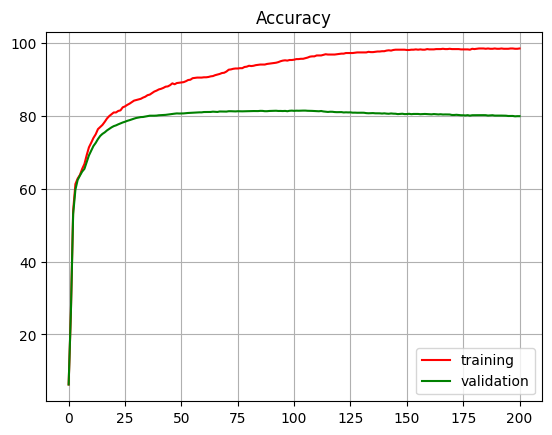

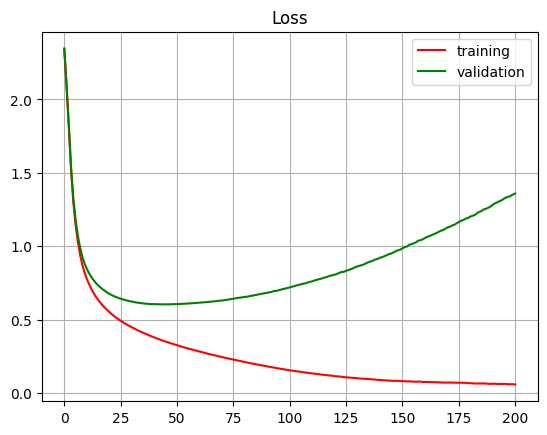

In [47]:
train_model(X_train,Y_train, X_test, Y_test, epoch=epochs,batch_size=b_sz, num_neurons_hidden = neuros_num, activation_functions = act_func,
                weights_init_type=weight_init, optimizer = optimizer, learning_rate = lr, w_d = w_d, plot_acc_loss=True)

In [ ]:
act_func = act_func + ['softmax']

In [ ]:
i, o = forward_propagation(X_test, Ws, bs, act_func)

In [ ]:
y = o[-1]

In [ ]:
y[:,0].argmax()

9

In [ ]:
Y_test[:,0].argmax()

9

In [ ]:
from itertools import count
print(Y_test.shape[1])
print(y.shape[1])
count = 0
for i in range(Y_test.shape[1]):
  if Y_test[:,i].argmax() == y[:,i].argmax():
    count += 1
print((count/Y_test.shape[1])*100)

10000
10000
85.59
